In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Multiply, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.metrics import MeanSquaredError, Precision
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_ratings = pd.read_pickle('/content/drive/My Drive/df_ratings_100k.pkl')
df_movies = pd.read_pickle('/content/drive/My Drive/df_movies_cleaned.pkl')

Now, we will implement the popular Neural Collaborative Filtering (NCF) algorithm for our movie recommendation system. NCF is a powerful algorithm that leverages neural networks to learn complex user-item interactions, making it particularly effective for recommendation tasks due to its ability to capture both linear and non-linear relationships.

NCF works by representing users and items with embedding vectors learned during training, which capture latent features. These embeddings are then combined using neural network architectures. The Generalized Matrix Factorization (GMF) approach computes the dot product of user and item embeddings, while the Multi-Layer Perceptron (MLP) approach concatenates the embeddings and passes them through multiple hidden layers. Neural Matrix Factorization (NeuMF) combines GMF and MLP to capture both linear and non-linear interactions, producing a prediction score that represents the estimated preference of a user for a given item.

# 1. Preprocessing

## 1.1 Convert UserId & MovieId

Here, user IDs and movie IDs need to be converted to a continuous range of integers, which will serve as array indices in the embedding layers. Neural network models, particularly those using embeddings, benefit from having user and movie indices start from zero and continue without gaps. This is because each index directly accesses a position in the embedding matrix. This step ensures that each user and movie can be uniquely identified with a dense vector in the latent space.

In [5]:
# Combine all movie IDs and user IDs from both dataframes to ensure comprehensive encoding
all_movie_ids = pd.concat([df_ratings['movieId'], df_movies['movieId']]).unique()
all_user_ids = df_ratings['userId'].unique()

# Create and fit the encoders
movie_encoder = LabelEncoder()
user_encoder = LabelEncoder()

movie_encoder.fit(all_movie_ids)
user_encoder.fit(all_user_ids)

# Transform movie and user IDs in the both dataframes
df_ratings['user'] = user_encoder.transform(df_ratings['userId'])
df_ratings['movie'] = movie_encoder.transform(df_ratings['movieId'])
df_movies['movie'] = movie_encoder.transform(df_movies['movieId'])

In [6]:
# Check Encoding:

num_users = df_ratings['user'].nunique()
num_movies = df_ratings['movie'].nunique()

print("Unique users in ratings:", num_users)
print("Unique movies in ratings:", num_movies)
print("Min/Max user IDs:", df_ratings['user'].min(), '/', df_ratings['user'].max())
print("Min/Max movie IDs:", df_ratings['movie'].min(), '/', df_ratings['movie'].max())

Unique users in ratings: 55588
Unique movies in ratings: 9494
Min/Max user IDs: 0 / 55587
Min/Max movie IDs: 0 / 39082


User IDs appear to be correctly encoded. We have 55,588 unique users, and the user IDs range from 0 to 55,587, which suggests that every unique user ID has been mapped to a unique integer in a contiguous zero-based range.

Movie IDs, however, show a discrepancy. While there are 9,494 unique movies, the movie IDs range from 0 to 39,082. This gap indicates that not all possible integer values between 0 and 39,082 are used, suggesting that there are missing IDs within this range. Therefore, we will remap the movie IDs to a new contiguous range.

In [7]:
# Recreate the mapping from the sorted unique IDs
movie_id_map = {id: i for i, id in enumerate(sorted(df_ratings['movieId'].unique()))}

# Apply the new mapping to the DataFrames
df_ratings['movie'] = df_ratings['movieId'].apply(lambda x: movie_id_map.get(x, -1))  # Use get to avoid errors
df_movies['movie'] = df_movies['movieId'].apply(lambda x: movie_id_map.get(x, -1))

# Check again
print("New max movie ID in ratings:", df_ratings['movie'].max())
print("New unique movie IDs in ratings:", df_ratings['movie'].nunique())

New max movie ID in ratings: 9493
New unique movie IDs in ratings: 9494


In [8]:
print(df_ratings[['movieId', 'movie']].head())
print(df_movies[['movieId', 'movie']].head())

          movieId  movie
11800835     1037    829
3192182     27316   5716
10041143      307    269
14911364    73929   7389
13024846     4308   3281
   movieId  movie
0        1      0
1        2      1
2        3      2
3        4      3
4        5      4


The mapping has now been applied correctly. The movie IDs now range from 0 to 9493, which matches exactly with the count of unique movie IDs (9494), implying that the IDs are perfectly contiguous and zero-indexed. Let's do a final validation check to confirm that no movieId is left unmapped and no erroneous transformations have occurred:

In [9]:
# Ensure that all movies referenced in ratings are available in the movies DataFrame
missing_movies = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
if missing_movies.empty:
    print("All movies in ratings are accounted for in the movies dataframe.")
else:
    print(f"There are {missing_movies.shape[0]} missing movies in the movies dataframe.")

There are 781 missing movies in the movies dataframe.


The presence of 781 missing movies in the df_movies DataFrame compared to df_ratings indicates that there are movies which have been rated but for which there is no additional metadata available in the df_movies dataset. Those rows will be dropped as they are not significant for the model.

In [10]:
# Removing ratings with missing movie metadata
df_ratings = df_ratings[df_ratings['movie'].isin(df_movies['movie'])]

# Check again
missing_movies_after = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
if missing_movies_after.empty:
    print("All movies in ratings are now accounted for in the movies dataframe.")
else:
    print(f"There are still {missing_movies_after.shape[0]} missing movies in the movies dataframe.")

All movies in ratings are now accounted for in the movies dataframe.


The data is now correctly encoded and we can move on to the next preprocessing step.

## 1.2 Normalize Ratings

Next, we normalize the ratings as this helps the model train faster and converge more easily.

In [11]:
# Normalize the ratings to a scale of 0 to 1
df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5

In [12]:
# Check Normalization:

print("Min/Max normalized ratings:", df_ratings['rating_norm'].min(), "/", df_ratings['rating_norm'].max())
print(df_ratings[['rating', 'rating_norm']].head())

Min/Max normalized ratings: 0.0 / 1.0
          rating  rating_norm
11800835     0.5          0.0
3192182      0.5          0.0
10041143     0.5          0.0
14911364     0.5          0.0
13024846     0.5          0.0


## 1.3 Prepare Data for Modelling

Now, we split the data into training and test data. For recommendation tasks, a chronological split makes more sense than a random split because user preferences and item popularity can change over time. Using a chronological split can simulate a real-world scenario where a model trained on past data is used to predict future preferences. This approach helps in evaluating how well the model might perform when deployed in production, as it mimics the model's need to work with new, unseen data arriving over time.

In [13]:
# Sort data chronologically
df_ratings = df_ratings.sort_values(by='timestamp')

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Define a cutoff for splitting the data (70% train, 15% validation, 15% test)
train_cutoff = int(len(df_ratings) * train_ratio)
val_cutoff = int(len(df_ratings) * (train_ratio + val_ratio))

train_df = df_ratings.iloc[:train_cutoff]
val_df = df_ratings.iloc[train_cutoff:val_cutoff]
test_df = df_ratings.iloc[val_cutoff:]

In [14]:
# Separate user and item IDs for training, validation, and testing
X_train_user = train_df['user'].values
X_train_item = train_df['movie'].values
y_train = train_df['rating_norm'].values

X_val_user = val_df['user'].values
X_val_item = val_df['movie'].values
y_val = val_df['rating_norm'].values

X_test_user = test_df['user'].values
X_test_item = test_df['movie'].values
y_test = test_df['rating_norm'].values

# Convert to TensorFlow tensors
X_train_user = tf.convert_to_tensor(X_train_user, dtype=tf.int32)
X_train_item = tf.convert_to_tensor(X_train_item, dtype=tf.int32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

X_val_user = tf.convert_to_tensor(X_val_user, dtype=tf.int32)
X_val_item = tf.convert_to_tensor(X_val_item, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

X_test_user = tf.convert_to_tensor(X_test_user, dtype=tf.int32)
X_test_item = tf.convert_to_tensor(X_test_item, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [15]:
# Verify the shapes of the tensors
print(f"X_train_user shape: {X_train_user.shape}")
print(f"X_train_item shape: {X_train_item.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_val_user shape: {X_val_user.shape}")
print(f"X_val_item shape: {X_val_item.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"X_test_user shape: {X_test_user.shape}")
print(f"X_test_item shape: {X_test_item.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_user shape: (69453,)
X_train_item shape: (69453,)
y_train shape: (69453,)
X_val_user shape: (14883,)
X_val_item shape: (14883,)
y_val shape: (14883,)
X_test_user shape: (14883,)
X_test_item shape: (14883,)
y_test shape: (14883,)


In [16]:
# Check Train-Test-Split:
print("Train data range from {} to {}".format(train_df['timestamp'].min(), train_df['timestamp'].max()))
print("Validation data range from {} to {}".format(val_df['timestamp'].min(), val_df['timestamp'].max()))
print("Test data range from {} to {}".format(test_df['timestamp'].min(), test_df['timestamp'].max()))

Train data range from 1996-02-15 12:59:58 to 2011-06-05 12:22:52
Validation data range from 2011-06-05 13:20:38 to 2015-11-07 15:07:54
Test data range from 2015-11-07 15:11:41 to 2017-08-04 03:38:23


# 2. Model Building

After the data preprocessing steps, we can now define the model architecture as previously described and train the model on our data.

## 2.1 Define the NCF Model Architecture

In this model, the user and item inputs are embedded into 10-dimensional vectors for both the GMF and MLP parts. The GMF component multiplies the user and item embeddings, while the MLP component concatenates them and passes them through three dense layers with ReLU activations, reducing the dimensionality from 64 to 16. This structure allows the MLP part to capture complex, non-linear relationships between users and items.

The outputs of the GMF and MLP components are then concatenated and passed through additional dense layers to combine the linear and non-linear interaction features, further refining the representation before the final output. The final layer uses a sigmoid activation function to produce a prediction score between 0 and 1, representing the estimated preference of a user for a given item.

The model is compiled with the Adam optimizer for efficient gradient descent, and the loss function is mean squared error (MSE), which is the most appropriate for rating predictions.

In [17]:
# Define model parameters
embedding_size = 10

# GMF part
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding_gmf = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_gmf')(user_input)
item_embedding_gmf = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_gmf')(item_input)
gmf_vector = Multiply()([Flatten()(user_embedding_gmf), Flatten()(item_embedding_gmf)])

# MLP part
user_embedding_mlp = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_mlp')(user_input)
item_embedding_mlp = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_mlp')(item_input)
mlp_vector = Concatenate()([Flatten()(user_embedding_mlp), Flatten()(item_embedding_mlp)])

mlp_vector = Dense(64, activation='relu')(mlp_vector)
mlp_vector = Dense(32, activation='relu')(mlp_vector)
mlp_vector = Dense(16, activation='relu')(mlp_vector)

# Combine GMF and MLP parts
concatenated = Concatenate()([gmf_vector, mlp_vector])
result = Dense(10, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(result)

# Define a custom RMSE metric
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae', MeanSquaredError(name='mse'), root_mean_squared_error, Precision(thresholds=0.778, name='precision')]) # treshold of 0.778 (equivalent to 4 on a 0.5 - 5 scale)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding_mlp (Embedd  (None, 1, 10)                555880    ['user_input[0][0]']          
 ing)                                                                                             
                                                                                                  
 item_embedding_mlp (Embedd  (None, 1, 10)                94940     ['item_input[0][0]']      

## 2.2 Train the model

In [18]:
# Train the model
history = model.fit(
    [X_train_user, X_train_item],
    y_train,
    epochs=20,
    batch_size=256,
    validation_data=([X_val_user, X_val_item], y_val)
)

Epoch 1/20
272/272 [==============================] - 13s 33ms/step - loss: 0.0533 - mae: 0.1835 - mse: 0.0533 - root_mean_squared_error: 0.2300 - precision: 0.9984 - val_loss: 0.0496 - val_mae: 0.1717 - val_mse: 0.0496 - val_root_mean_squared_error: 0.2215 - val_precision: 0.9882
Epoch 2/20
272/272 [==============================] - 2s 9ms/step - loss: 0.0376 - mae: 0.1479 - mse: 0.0376 - root_mean_squared_error: 0.1936 - precision: 0.9989 - val_loss: 0.0516 - val_mae: 0.1763 - val_mse: 0.0516 - val_root_mean_squared_error: 0.2261 - val_precision: 0.9891
Epoch 3/20
272/272 [==============================] - 1s 5ms/step - loss: 0.0253 - mae: 0.1189 - mse: 0.0253 - root_mean_squared_error: 0.1586 - precision: 0.9998 - val_loss: 0.0531 - val_mae: 0.1779 - val_mse: 0.0531 - val_root_mean_squared_error: 0.2295 - val_precision: 0.9888
Epoch 4/20
272/272 [==============================] - 2s 7ms/step - loss: 0.0162 - mae: 0.0947 - mse: 0.0162 - root_mean_squared_error: 0.1272 - precision: 0.

## 2.3 Evaluate the model

Let's evaluate the model by applying it to a test set that it has not seen before, visualizing the metric evolution across epochs and printing the first 10 movies for an exemplary user.

In [19]:
# Evaluate model on the test set
results = model.evaluate([X_test_user, X_test_item], y_test, verbose=1)

466/466 [==============================] - 1s 2ms/step - loss: 0.0562 - mae: 0.1852 - mse: 0.0562 - root_mean_squared_error: 0.2340 - precision: 0.9839


In [20]:
# Scale back MAE, MSE, and RMSE to the original rating scale (0.5 to 5)
scale_factor = 4.5
scaled_mae = results[1] * scale_factor
scaled_mse = results[2] * (scale_factor ** 2)
scaled_rmse = results[3] * scale_factor

# Print all metrics
print("Test Loss (MSE): {:.4f}".format(results[0]))
print("Test MAE: {:.4f}".format(scaled_mae))
print("Test MSE: {:.4f}".format(scaled_mse))
print("Test RMSE: {:.4f}".format(scaled_rmse))
print("Test Precision: {:.4f}".format(results[4]))

Test Loss (MSE): 0.0562
Test MAE: 0.8333
Test MSE: 1.1389
Test RMSE: 1.0528
Test Precision: 0.9839


In [21]:
# Function to visualize results
def visualize_results(history):
    """Generate plots to visualize model results."""
    plt.figure(figsize=(18, 10))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot MAE
    plt.subplot(2, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE Over Epochs')
    plt.legend()

    # Plot MSE
    plt.subplot(2, 2, 3)
    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title('MSE Over Epochs')
    plt.legend()

    # Plot RMSE
    plt.subplot(2, 2, 4)
    plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('RMSE Over Epochs')
    plt.legend()

    plt.show()

    # Plot Precision
    if 'precision' in history.history:
        plt.figure(figsize=(9, 5))
        plt.plot(history.history['precision'], label='Train Precision')
        plt.plot(history.history['val_precision'], label='Validation Precision')
        plt.title('Precision Over Epochs')
        plt.legend()
        plt.show()

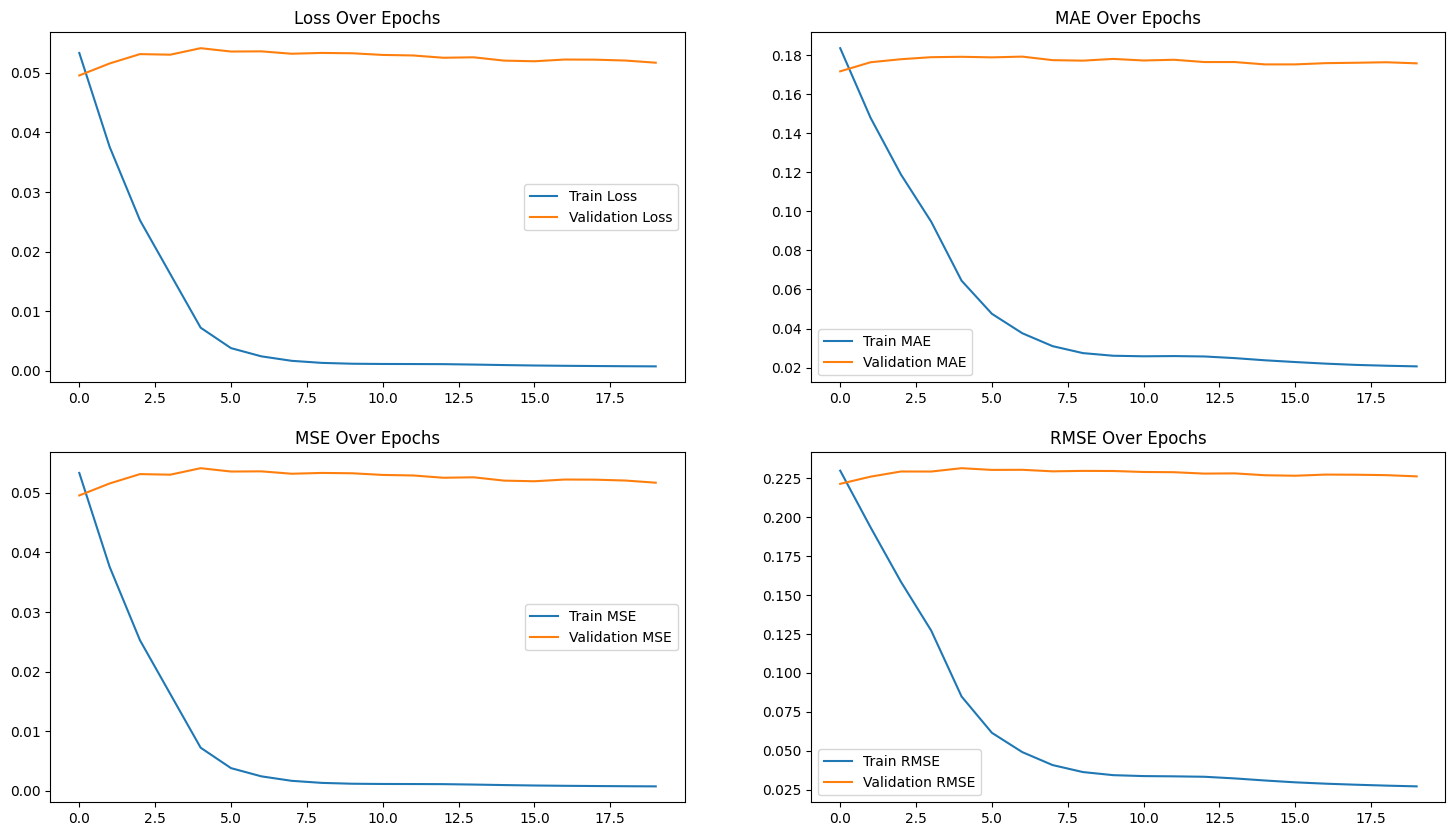

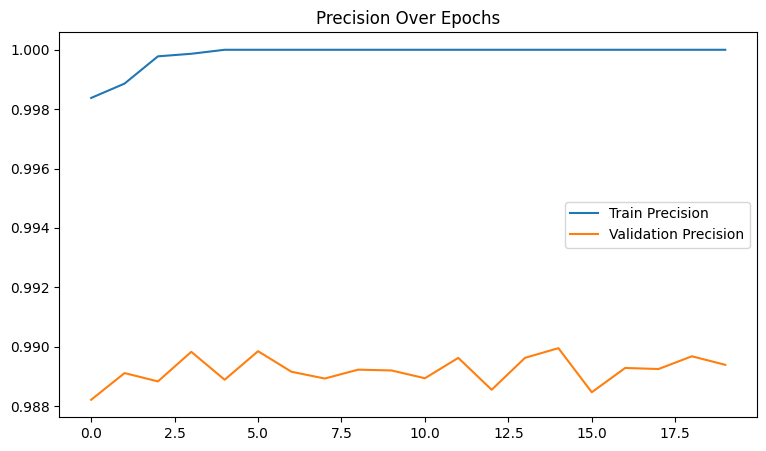

In [22]:
visualize_results(history)

In [23]:
# Select an exemplary user
exemplary_user_id = 4

# Encode the exemplary user ID
encoded_user_id = user_encoder.transform([exemplary_user_id])[0]

# Get a list of all movie IDs
all_movie_ids = df_movies['movie'].unique()

# Get the list of movies the user has already rated
rated_movies = df_ratings[df_ratings['userId'] == exemplary_user_id]['movieId'].unique()

# Filter out the movies the user has already rated
unrated_movie_ids = np.setdiff1d(all_movie_ids, rated_movies)

# Prepare input data for the model
user_input = np.full(len(unrated_movie_ids), encoded_user_id)
movie_input = unrated_movie_ids

# Convert to TensorFlow tensors
user_input_tensor = tf.convert_to_tensor(user_input, dtype=tf.int32)
movie_input_tensor = tf.convert_to_tensor(movie_input, dtype=tf.int32)

# Make predictions
predicted_ratings_scaled = model.predict([user_input_tensor, movie_input_tensor])
predicted_ratings = predicted_ratings_scaled * 4.5 + 0.5

# Combine movie IDs with their predicted ratings
movie_ratings = list(zip(movie_input, predicted_ratings.flatten()))

# Sort movies by predicted rating in descending order
sorted_movie_ratings = sorted(movie_ratings, key=lambda x: x[1], reverse=True)

# Get top-N recommendations
top_n = 10
top_n_recommendations = sorted_movie_ratings[:top_n]

# Print top-N recommendations
print(f"Top {top_n} movie recommendations for User {exemplary_user_id}:")
for i, (movie_id, predicted_rating) in enumerate(top_n_recommendations, start=1):
    original_movie_id = movie_encoder.inverse_transform([movie_id])[0]
    movie_title = df_movies[df_movies['movieId'] == original_movie_id]['title'].values[0]
    print(f"Rank {i}: Movie ID {original_movie_id}, Title: {movie_title}, Predicted Rating: {predicted_rating: .2f}")

289/289 [==============================] - 1s 1ms/step
Top 10 movie recommendations for User 4:
Rank 1: Movie ID 1020, Title: Cool Runnings, Predicted Rating:  4.39
Rank 2: Movie ID 2619, Title: Mascara, Predicted Rating:  4.38
Rank 3: Movie ID 3333, Title: The Killing of Sister George, Predicted Rating:  4.36
Rank 4: Movie ID 290, Title: Once Were Warriors, Predicted Rating:  4.30
Rank 5: Movie ID 3607, Title: One Little Indian, Predicted Rating:  4.28
Rank 6: Movie ID 728, Title: Cold Comfort Farm, Predicted Rating:  4.28
Rank 7: Movie ID 1099, Title: A Christmas Carol, Predicted Rating:  4.27
Rank 8: Movie ID 2618, Title: The Castle, Predicted Rating:  4.27
Rank 9: Movie ID 1067, Title: A Damsel in Distress, Predicted Rating:  4.26
Rank 10: Movie ID 1302, Title: Field of Dreams, Predicted Rating:  4.25


**Interpretation:**

The test results indicate a Test Loss (MSE) of 0.0562, which suggests the model's prediction errors are relatively small on average. The Mean Absolute Error (MAE) on the test set is 0.8333, indicating that the average absolute difference between the predicted and actual ratings is about 0.83. This MAE value, while not perfect, shows that the model's predictions are reasonably close to the true ratings. The Test MSE of 1.1389 and RMSE of 1.0528 further corroborate the model's effectiveness in minimizing prediction errors, with RMSE providing a more interpretable error metric by being in the same units as the original ratings.

The precision metric, calculated at 0.9839, demonstrates the model's high accuracy in predicting relevant items for users. This means that 98.39% of the items that the model predicted as relevant (above the threshold 4) were indeed relevant based on the test set.

The plots of the metric evolution over epochs illustrate that while the training metrics (MSE, RMSE, and Precision) improve consistently, the validation metrics exhibit a degree of stability with minor fluctuations, particularly in precision. This suggests that the model generalizes well to unseen data without significant overfitting.

## 2.4 Harnessing larger datasets

Now, given the fact that Deep Neural Networks perform better and better the more data they are given, we will try our model with bigger datasets, namely one dataset with 1 million entries and another one with 3 million entries (as opposed to 100k in the first iteration).

### 2.4.1 Define Functions

Now, let's define functions with the preprocessing and modelling steps which we did before.

In [24]:
def prepare_data(df_ratings, df_movies):
  # Combine all movie IDs and user IDs from both dataframes to ensure comprehensive encoding
  all_movie_ids = pd.concat([df_ratings['movieId'], df_movies['movieId']]).unique()
  all_user_ids = df_ratings['userId'].unique()

  # Create and fit the encoders
  movie_encoder = LabelEncoder()
  user_encoder = LabelEncoder()

  movie_encoder.fit(all_movie_ids)
  user_encoder.fit(all_user_ids)

  # Transform movie and user IDs in the both dataframes
  df_ratings['user'] = user_encoder.transform(df_ratings['userId'])
  df_ratings['movie'] = movie_encoder.transform(df_ratings['movieId'])
  df_movies['movie'] = movie_encoder.transform(df_movies['movieId'])

  # Check Encoding:
  num_users = df_ratings['user'].nunique()
  num_movies = df_ratings['movie'].nunique()

  print("Unique users in ratings:", num_users)
  print("Unique movies in ratings:", num_movies)
  print("Min/Max user IDs:", df_ratings['user'].min(), '/', df_ratings['user'].max())
  print("Min/Max movie IDs:", df_ratings['movie'].min(), '/', df_ratings['movie'].max())

  # Recreate the mapping from the sorted unique IDs
  movie_id_map = {id: i for i, id in enumerate(sorted(df_ratings['movieId'].unique()))}

  # Apply the new mapping to the DataFrames
  df_ratings['movie'] = df_ratings['movieId'].apply(lambda x: movie_id_map.get(x, -1))  # Use get to avoid errors
  df_movies['movie'] = df_movies['movieId'].apply(lambda x: movie_id_map.get(x, -1))

  # Check again
  print("New max movie ID in ratings:", df_ratings['movie'].max())
  print("New unique movie IDs in ratings:", df_ratings['movie'].nunique())

  print(df_ratings[['movieId', 'movie']].head())
  print(df_movies[['movieId', 'movie']].head())

  # Ensure that all movies referenced in ratings are available in the movies DataFrame
  missing_movies = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
  if missing_movies.empty:
      print("All movies in ratings are accounted for in the movies dataframe.")
  else:
      print(f"There are {missing_movies.shape[0]} missing movies in the movies dataframe.")

  # Removing ratings with missing movie metadata
  df_ratings = df_ratings[df_ratings['movie'].isin(df_movies['movie'])]

  # Check again
  missing_movies_after = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
  if missing_movies_after.empty:
      print("All movies in ratings are now accounted for in the movies dataframe.")
  else:
      print(f"There are still {missing_movies_after.shape[0]} missing movies in the movies dataframe.")

  # Normalize the ratings to a scale of 0 to 1
  df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5

  # Check Normalization:
  print("Min/Max normalized ratings:", df_ratings['rating_norm'].min(), "/", df_ratings['rating_norm'].max())
  print(df_ratings[['rating', 'rating_norm']].head())

  # Sort data chronologically
  df_ratings = df_ratings.sort_values(by='timestamp')

  # Define split ratios
  train_ratio = 0.7
  val_ratio = 0.15
  test_ratio = 0.15

  # Define a cutoff for splitting the data (70% train, 15% validation, 15% test)
  train_cutoff = int(len(df_ratings) * train_ratio)
  val_cutoff = int(len(df_ratings) * (train_ratio + val_ratio))

  train_df = df_ratings.iloc[:train_cutoff]
  val_df = df_ratings.iloc[train_cutoff:val_cutoff]
  test_df = df_ratings.iloc[val_cutoff:]

  # Separate user and item IDs for training, validation, and testing
  X_train_user = train_df['user'].values
  X_train_item = train_df['movie'].values
  y_train = train_df['rating_norm'].values

  X_val_user = val_df['user'].values
  X_val_item = val_df['movie'].values
  y_val = val_df['rating_norm'].values

  X_test_user = test_df['user'].values
  X_test_item = test_df['movie'].values
  y_test = test_df['rating_norm'].values

  # Convert to TensorFlow tensors
  X_train_user = tf.convert_to_tensor(X_train_user, dtype=tf.int32)
  X_train_item = tf.convert_to_tensor(X_train_item, dtype=tf.int32)
  y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

  X_val_user = tf.convert_to_tensor(X_val_user, dtype=tf.int32)
  X_val_item = tf.convert_to_tensor(X_val_item, dtype=tf.int32)
  y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

  X_test_user = tf.convert_to_tensor(X_test_user, dtype=tf.int32)
  X_test_item = tf.convert_to_tensor(X_test_item, dtype=tf.int32)
  y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

  # Verify the shapes of the tensors
  print(f"X_train_user shape: {X_train_user.shape}")
  print(f"X_train_item shape: {X_train_item.shape}")
  print(f"y_train shape: {y_train.shape}")

  print(f"X_val_user shape: {X_val_user.shape}")
  print(f"X_val_item shape: {X_val_item.shape}")
  print(f"y_val shape: {y_val.shape}")

  print(f"X_test_user shape: {X_test_user.shape}")
  print(f"X_test_item shape: {X_test_item.shape}")
  print(f"y_test shape: {y_test.shape}")

  # Check Train-Test-Split:
  print("Train data range from {} to {}".format(train_df['timestamp'].min(), train_df['timestamp'].max()))
  print("Validation data range from {} to {}".format(val_df['timestamp'].min(), val_df['timestamp'].max()))
  print("Test data range from {} to {}".format(test_df['timestamp'].min(), test_df['timestamp'].max()))

  return X_train_user, X_train_item, y_train, X_val_user, X_val_item, y_val, X_test_user, X_test_item, y_test, user_encoder, movie_encoder

In [25]:
def build_and_train_model(X_train_user, X_train_item, y_train, X_val_user, X_val_item, y_val, num_users, num_movies, embedding_size=10, epochs=20, batch_size=256):
    # GMF part
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')

    user_embedding_gmf = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_gmf')(user_input)
    item_embedding_gmf = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_gmf')(item_input)
    gmf_vector = Multiply()([Flatten()(user_embedding_gmf), Flatten()(item_embedding_gmf)])

    # MLP part
    user_embedding_mlp = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_mlp')(user_input)
    item_embedding_mlp = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_mlp')(item_input)
    mlp_vector = Concatenate()([Flatten()(user_embedding_mlp), Flatten()(item_embedding_mlp)])

    mlp_vector = Dense(64, activation='relu')(mlp_vector)
    mlp_vector = Dense(32, activation='relu')(mlp_vector)
    mlp_vector = Dense(16, activation='relu')(mlp_vector)

    # Combine GMF and MLP parts
    concatenated = Concatenate()([gmf_vector, mlp_vector])
    result = Dense(10, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(result)

    # Define a custom RMSE metric
    def root_mean_squared_error(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mae', MeanSquaredError(name='mse'), root_mean_squared_error, Precision(thresholds=0.778, name='precision')])
    model.summary()

    # Train the model
    history = model.fit(
        [X_train_user, X_train_item],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_val_user, X_val_item], y_val)
    )

    return model, history

In [26]:
def evaluate_model(model, X_test_user, X_test_item, y_test):
    # Evaluate model on the test set
    results = model.evaluate([X_test_user, X_test_item], y_test, verbose=1)

    # Scale back MAE, MSE, and RMSE to the original rating scale (0.5 to 5)
    scale_factor = 4.5
    scaled_mae = results[1] * scale_factor
    scaled_mse = results[2] * (scale_factor ** 2)
    scaled_rmse = results[3] * scale_factor

    # Print all metrics
    print("Test Loss (MSE): {:.4f}".format(results[0]))
    print("Test MAE: {:.4f}".format(scaled_mae))
    print("Test MSE: {:.4f}".format(scaled_mse))
    print("Test RMSE: {:.4f}".format(scaled_rmse))
    print("Test Precision: {:.2f}%".format(results[4] * 100))

In [27]:
def get_recommendations_for_user(model, exemplary_user_id, user_encoder, movie_encoder, df_ratings, df_movies, top_n=10):
    # Encode the exemplary user ID
    encoded_user_id = user_encoder.transform([exemplary_user_id])[0]

    # Get a list of all movie IDs
    all_movie_ids = df_movies['movie'].unique()

    # Get the list of movies the user has already rated
    rated_movies = df_ratings[df_ratings['userId'] == exemplary_user_id]['movieId'].unique()

    # Filter out the movies the user has already rated
    unrated_movie_ids = np.setdiff1d(all_movie_ids, rated_movies)

    # Prepare input data for the model
    user_input = np.full(len(unrated_movie_ids), encoded_user_id)
    movie_input = unrated_movie_ids

    # Convert to TensorFlow tensors
    user_input_tensor = tf.convert_to_tensor(user_input, dtype=tf.int32)
    movie_input_tensor = tf.convert_to_tensor(movie_input, dtype=tf.int32)

    # Make predictions
    predicted_ratings_scaled = model.predict([user_input_tensor, movie_input_tensor])
    predicted_ratings = predicted_ratings_scaled * 4.5 + 0.5

    # Combine movie IDs with their predicted ratings
    movie_ratings = list(zip(movie_input, predicted_ratings.flatten()))

    # Sort movies by predicted rating in descending order
    sorted_movie_ratings = sorted(movie_ratings, key=lambda x: x[1], reverse=True)

    # Get top-N recommendations
    top_n_recommendations = sorted_movie_ratings[:top_n]

    # Print top-N recommendations
    print(f"Top {top_n} movie recommendations for User {exemplary_user_id}:")
    for i, (movie_id, predicted_rating) in enumerate(top_n_recommendations, start=1):
        original_movie_id = movie_encoder.inverse_transform([movie_id])[0]
        movie_title = df_movies[df_movies['movieId'] == original_movie_id]['title'].values[0]
        print(f"Rank {i}: Movie ID {original_movie_id}, Title: {movie_title}, Predicted Rating: {predicted_rating:.2f}")

### 2.4.2   1 Mio. Dataset

In [28]:
# 1 Mio Ratings:

df_ratings = pd.read_pickle('/content/drive/My Drive/df_ratings_1M.pkl')

In [29]:
# Prepare data
prepare_data(df_ratings, df_movies)

Unique users in ratings: 145430
Unique movies in ratings: 19596
Min/Max user IDs: 0 / 145429
Min/Max movie IDs: 0 / 40057
New max movie ID in ratings: 19595
New unique movie IDs in ratings: 19596
          movieId  movie
11800835     1037    985
3192182     27316   8398
10041143      307    302
14911364    73929  12086
13024846     4308   4059
   movieId  movie
0        1      0
1        2      1
2        3      2
3        4      3
4        5      4
There are 7743 missing movies in the movies dataframe.
All movies in ratings are now accounted for in the movies dataframe.
Min/Max normalized ratings: 0.0 / 1.0
          rating  rating_norm
11800835     0.5          0.0
3192182      0.5          0.0
10041143     0.5          0.0
14911364     0.5          0.0
13024846     0.5          0.0


<ipython-input-24-bc499fa49e4f>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5


X_train_user shape: (694580,)
X_train_item shape: (694580,)
y_train shape: (694580,)
X_val_user shape: (148839,)
X_val_item shape: (148839,)
y_val shape: (148839,)
X_test_user shape: (148839,)
X_test_item shape: (148839,)
y_test shape: (148839,)
Train data range from 1996-02-01 14:33:33 to 2011-04-28 02:16:07
Validation data range from 2011-04-28 02:18:17 to 2015-11-04 05:54:57
Test data range from 2015-11-04 06:02:22 to 2017-08-04 06:07:50


(<tf.Tensor: shape=(694580,), dtype=int32, numpy=array([ 51159, 116612, 123709, ...,  29189,  29189,  29189], dtype=int32)>,
 <tf.Tensor: shape=(694580,), dtype=int32, numpy=array([  62,   47,   86, ..., 8620, 6463, 2251], dtype=int32)>,
 <tf.Tensor: shape=(694580,), dtype=float32, numpy=
 array([0.11111111, 0.5555556 , 0.5555556 , ..., 0.7777778 , 0.7777778 ,
        0.44444445], dtype=float32)>,
 <tf.Tensor: shape=(148839,), dtype=int32, numpy=array([29189, 29189, 29189, ..., 46154, 46154, 73222], dtype=int32)>,
 <tf.Tensor: shape=(148839,), dtype=int32, numpy=array([ 1858,  9791, 11037, ...,  8748,  6607,  7728], dtype=int32)>,
 <tf.Tensor: shape=(148839,), dtype=float32, numpy=
 array([0.22222222, 0.6666667 , 0.6666667 , ..., 1.        , 1.        ,
        0.7777778 ], dtype=float32)>,
 <tf.Tensor: shape=(148839,), dtype=int32, numpy=array([ 79401,  46154,  79401, ..., 108576, 108576, 108576], dtype=int32)>,
 <tf.Tensor: shape=(148839,), dtype=int32, numpy=array([11238,   357,  46

In [30]:
# Build and train the model
model, history = build_and_train_model(X_train_user, X_train_item, y_train, X_val_user, X_val_item, y_val, num_users, num_movies)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding_mlp (Embedd  (None, 1, 10)                555880    ['user_input[0][0]']          
 ing)                                                                                             
                                                                                                  
 item_embedding_mlp (Embedd  (None, 1, 10)                94940     ['item_input[0][0]']    

In [31]:
# Evaluate the model
evaluate_model(model, X_test_user, X_test_item, y_test)

466/466 [==============================] - 1s 2ms/step - loss: 0.0557 - mae: 0.1840 - mse: 0.0557 - root_mean_squared_error: 0.2329 - precision: 0.9859
Test Loss (MSE): 0.0557
Test MAE: 0.8280
Test MSE: 1.1278
Test RMSE: 1.0479
Test Precision: 98.59%


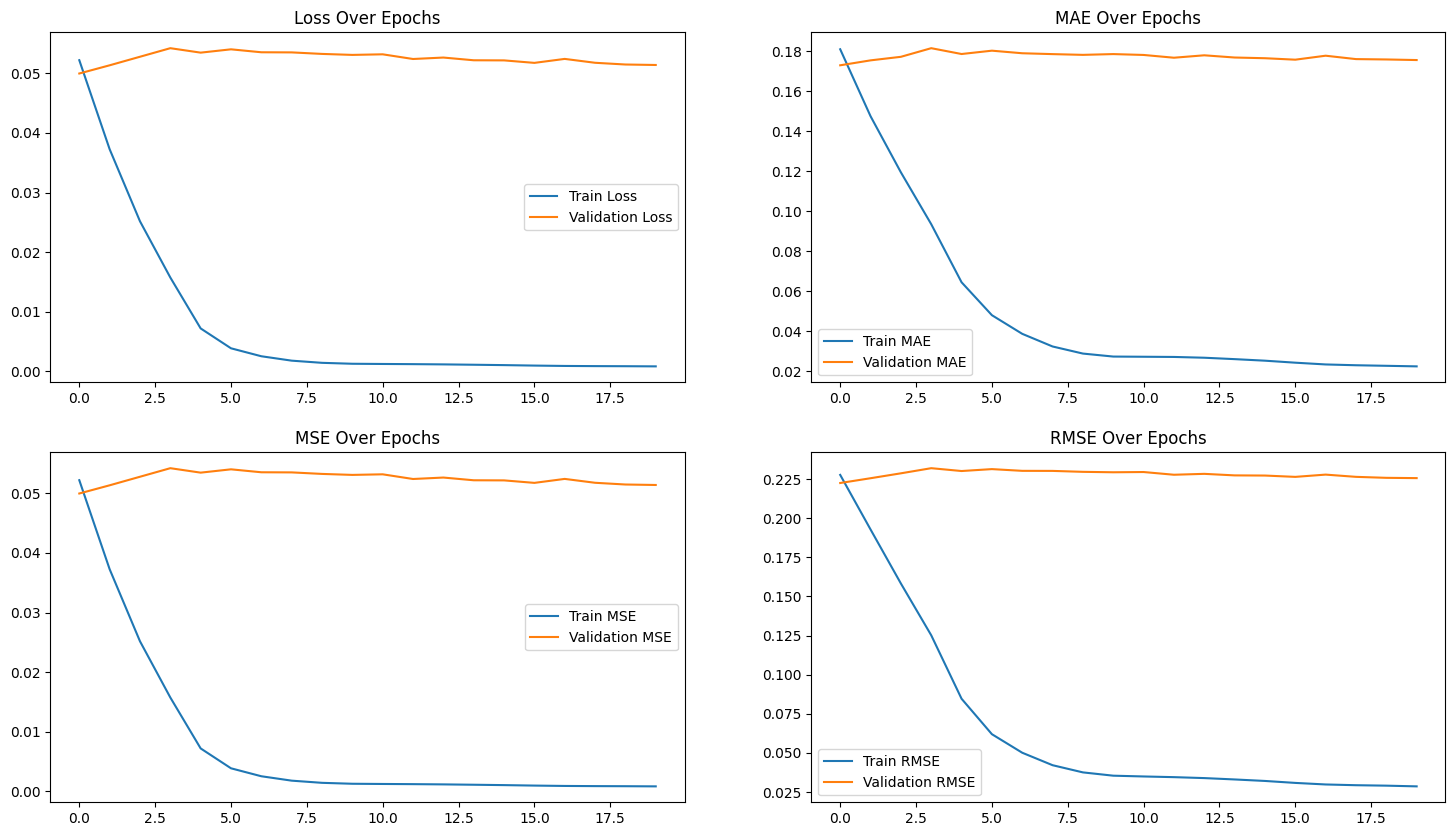

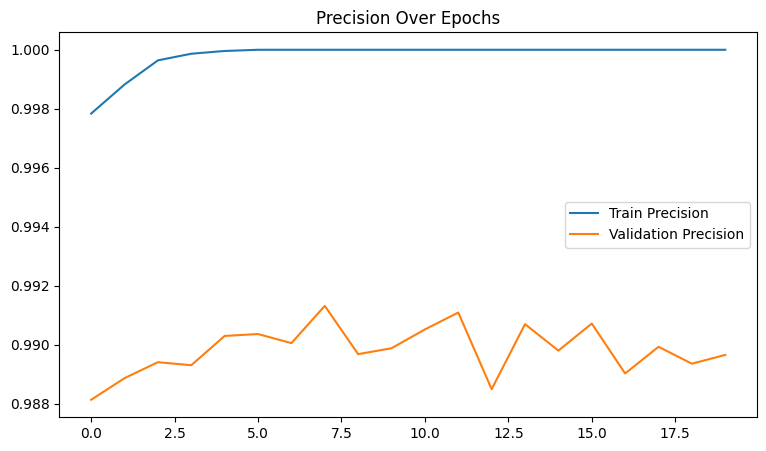

In [32]:
visualize_results(history)

In [33]:
# Get recommendations for an exemplary user
exemplary_user_id = 4
get_recommendations_for_user(model, exemplary_user_id, user_encoder, movie_encoder, df_ratings, df_movies)

575/575 [==============================] - 1s 1ms/step
Top 10 movie recommendations for User 4:
Rank 1: Movie ID 1757, Title: Fallen Angels, Predicted Rating: 4.51
Rank 2: Movie ID 1043, Title: To Gillian on Her 37th Birthday, Predicted Rating: 4.45
Rank 3: Movie ID 1020, Title: Cool Runnings, Predicted Rating: 4.42
Rank 4: Movie ID 2618, Title: The Castle, Predicted Rating: 4.41
Rank 5: Movie ID 3409, Title: Final Destination, Predicted Rating: 4.40
Rank 6: Movie ID 1099, Title: A Christmas Carol, Predicted Rating: 4.38
Rank 7: Movie ID 728, Title: Cold Comfort Farm, Predicted Rating: 4.34
Rank 8: Movie ID 482, Title: Killing Zoe, Predicted Rating: 4.32
Rank 9: Movie ID 774, Title: God's Gift, Predicted Rating: 4.31
Rank 10: Movie ID 2501, Title: October Sky, Predicted Rating: 4.29


### 2.4.3   3 Mio. Dataset

In [34]:
# 3 Mio Ratings:

df_ratings = pd.read_pickle('/content/drive/My Drive/df_ratings_3M.pkl')

In [35]:
# Prepare data
prepare_data(df_ratings, df_movies)

Unique users in ratings: 164638
Unique movies in ratings: 26876
Min/Max user IDs: 0 / 164637
Min/Max movie IDs: 0 / 41078
New max movie ID in ratings: 26875
New unique movie IDs in ratings: 26876
          movieId  movie
11800835     1037   1011
3192182     27316   9021
10041143      307    304
14911364    73929  13711
13024846     4308   4173
   movieId  movie
0        1      0
1        2      1
2        3      2
3        4      3
4        5      4
There are 22910 missing movies in the movies dataframe.
All movies in ratings are now accounted for in the movies dataframe.
Min/Max normalized ratings: 0.0 / 1.0
          rating  rating_norm
11800835     0.5          0.0
3192182      0.5          0.0
10041143     0.5          0.0
14911364     0.5          0.0
13024846     0.5          0.0


<ipython-input-24-bc499fa49e4f>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5


X_train_user shape: (2083963,)
X_train_item shape: (2083963,)
y_train shape: (2083963,)
X_val_user shape: (446564,)
X_val_item shape: (446564,)
y_val shape: (446564,)
X_test_user shape: (446564,)
X_test_item shape: (446564,)
y_test shape: (446564,)
Train data range from 1996-01-29 00:00:00 to 2011-04-29 02:10:57
Validation data range from 2011-04-29 02:11:19 to 2015-11-04 08:48:36
Test data range from 2015-11-04 08:48:45 to 2017-08-04 06:57:50


(<tf.Tensor: shape=(2083963,), dtype=int32, numpy=array([ 27632,  27632, 116093, ...,  54448,  87241,  54448], dtype=int32)>,
 <tf.Tensor: shape=(2083963,), dtype=int32, numpy=array([   1,   47,   10, ..., 1906, 6932,  373], dtype=int32)>,
 <tf.Tensor: shape=(2083963,), dtype=float32, numpy=
 array([0.7777778, 0.7777778, 0.7777778, ..., 0.5555556, 0.8888889,
        0.6666667], dtype=float32)>,
 <tf.Tensor: shape=(446564,), dtype=int32, numpy=array([54448, 33116, 54448, ..., 48681, 48681, 48681], dtype=int32)>,
 <tf.Tensor: shape=(446564,), dtype=int32, numpy=array([5120, 9183, 6469, ...,  471,    6, 5331], dtype=int32)>,
 <tf.Tensor: shape=(446564,), dtype=float32, numpy=
 array([0.5555556 , 0.7777778 , 0.44444445, ..., 0.22222222, 0.44444445,
        0.44444445], dtype=float32)>,
 <tf.Tensor: shape=(446564,), dtype=int32, numpy=array([103020,  48681,  48681, ..., 122806, 122806, 108999], dtype=int32)>,
 <tf.Tensor: shape=(446564,), dtype=int32, numpy=array([12423, 14954,  2820, ..., 

In [36]:
# Build and train the model
model, history = build_and_train_model(X_train_user, X_train_item, y_train, X_val_user, X_val_item, y_val, num_users, num_movies)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding_mlp (Embedd  (None, 1, 10)                555880    ['user_input[0][0]']          
 ing)                                                                                             
                                                                                                  
 item_embedding_mlp (Embedd  (None, 1, 10)                94940     ['item_input[0][0]']    

In [37]:
# Evaluate the model
evaluate_model(model, X_test_user, X_test_item, y_test)

466/466 [==============================] - 1s 2ms/step - loss: 0.0562 - mae: 0.1843 - mse: 0.0562 - root_mean_squared_error: 0.2338 - precision: 0.9852
Test Loss (MSE): 0.0562
Test MAE: 0.8294
Test MSE: 1.1372
Test RMSE: 1.0523
Test Precision: 98.52%


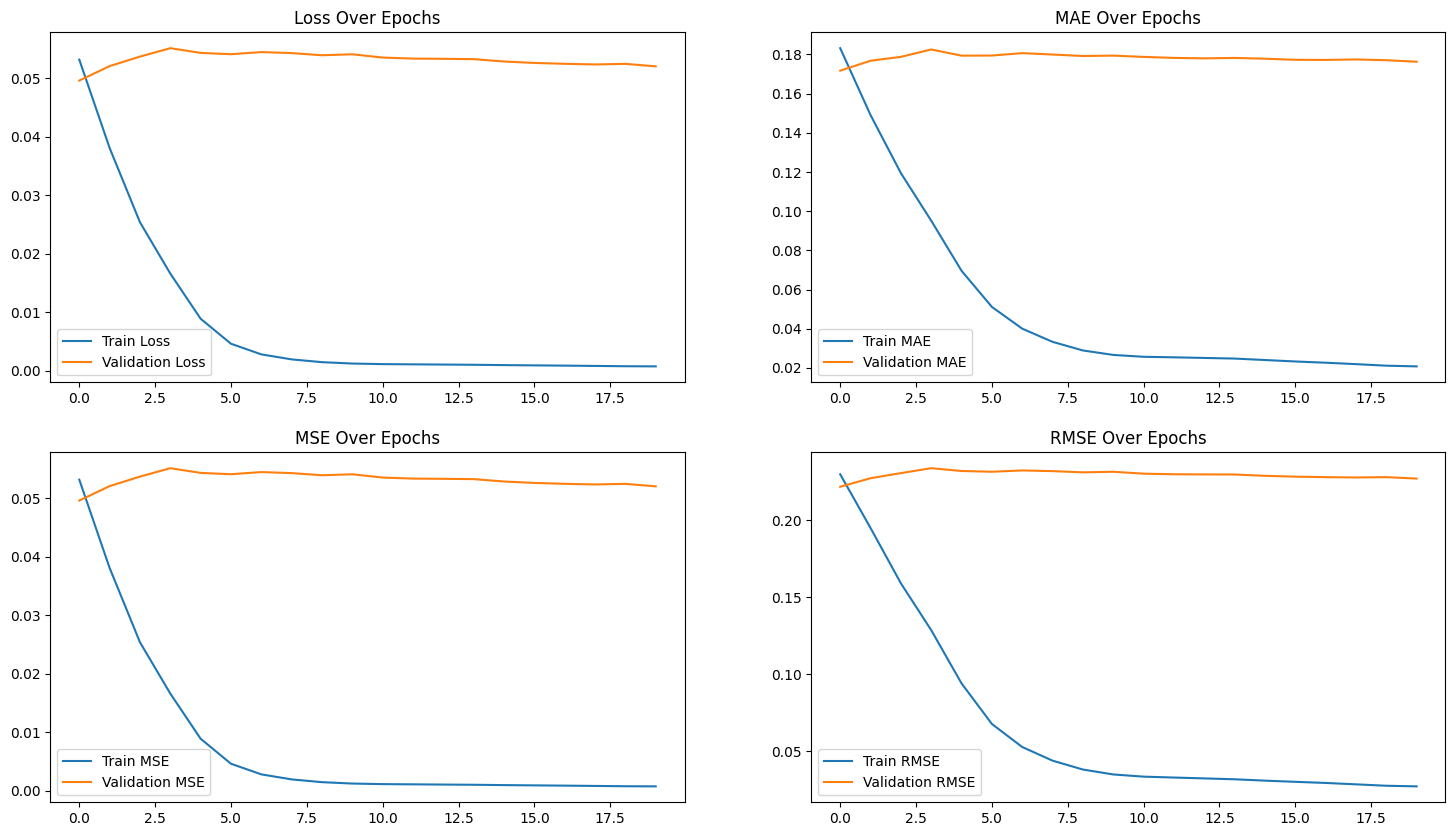

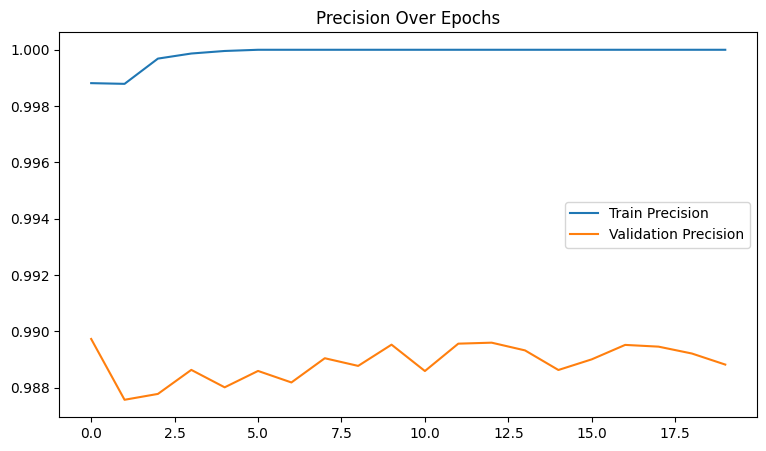

In [38]:
visualize_results(history)

In [39]:
# Get recommendations for an exemplary user
exemplary_user_id = 4
get_recommendations_for_user(model, exemplary_user_id, user_encoder, movie_encoder, df_ratings, df_movies)

771/771 [==============================] - 1s 2ms/step
Top 10 movie recommendations for User 4:
Rank 1: Movie ID 1757, Title: Fallen Angels, Predicted Rating: 4.49
Rank 2: Movie ID 1020, Title: Cool Runnings, Predicted Rating: 4.36
Rank 3: Movie ID 1032, Title: Alice in Wonderland, Predicted Rating: 4.23
Rank 4: Movie ID 1695, Title: Artemisia, Predicted Rating: 4.22
Rank 5: Movie ID 1957, Title: Chariots of Fire, Predicted Rating: 4.21
Rank 6: Movie ID 2501, Title: October Sky, Predicted Rating: 4.20
Rank 7: Movie ID 482, Title: Killing Zoe, Predicted Rating: 4.16
Rank 8: Movie ID 2619, Title: Mascara, Predicted Rating: 4.14
Rank 9: Movie ID 1899, Title: Passion in the Desert, Predicted Rating: 4.10
Rank 10: Movie ID 2658, Title: The Flying Saucer, Predicted Rating: 4.09


**Interpretation:**

The performance metrics for the model remain largely consistent across different dataset sizes. When increasing the dataset size to 1 million entries, the model achieves slightly better performance metrics compared to the initial 100k dataset. However, the improvements are marginal, with Test Loss (MSE), Test MSE, and Test RMSE showing only minor reductions and precision improving slightly to 98.59%.

With 3 million entries, the performance metrics are very similar to those obtained with 1 million entries. The Test Loss (MSE), Test MAE, Test MSE, and Test RMSE show minimal differences, and precision remains high at 98.52%.

These results indicate that increasing the dataset size did not bring significant benefits in terms of performance improvement. The metrics stay pretty much the same, suggesting that the model's ability to generalize and make accurate predictions does not significantly improve with more data beyond a certain point. Therefore, training the model with larger datasets did not provide substantial advantages in this case.